# Churn de Clientes con Red Neuronal

Lucho Ene | 2023 <br>
Come and Get Your Love by Redbone 

La pérdida de clientes, o deserción de clientes, es una métrica crucial para las empresas, y predecirla puede ayudar a las compañías a tomar medidas proactivas para retener a sus clientes.

## Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
import warnings

## Import dataset

In [2]:
df = pd.read_csv(r'Churn_Modelling_1.csv',index_col='RowNumber')
churn = df.copy()
churn.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
churn.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
churn.duplicated().sum()

0

In [6]:
churn.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
# Algunas columnas son totalmente improductivas, así que vamos a eliminarlas
churn.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

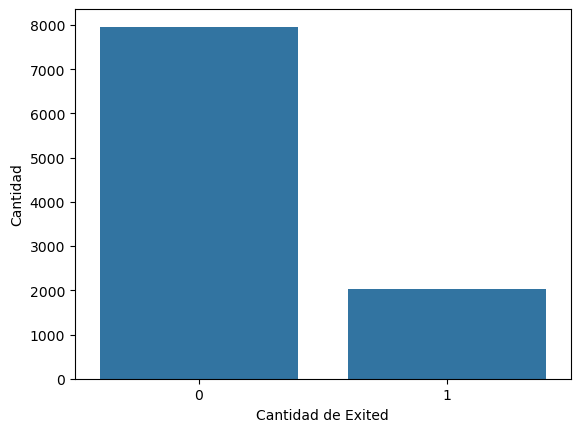

In [8]:
sns.countplot(x=churn['Exited'])
plt.xlabel('Cantidad de Exited')
plt.ylabel('Cantidad')
plt.show()

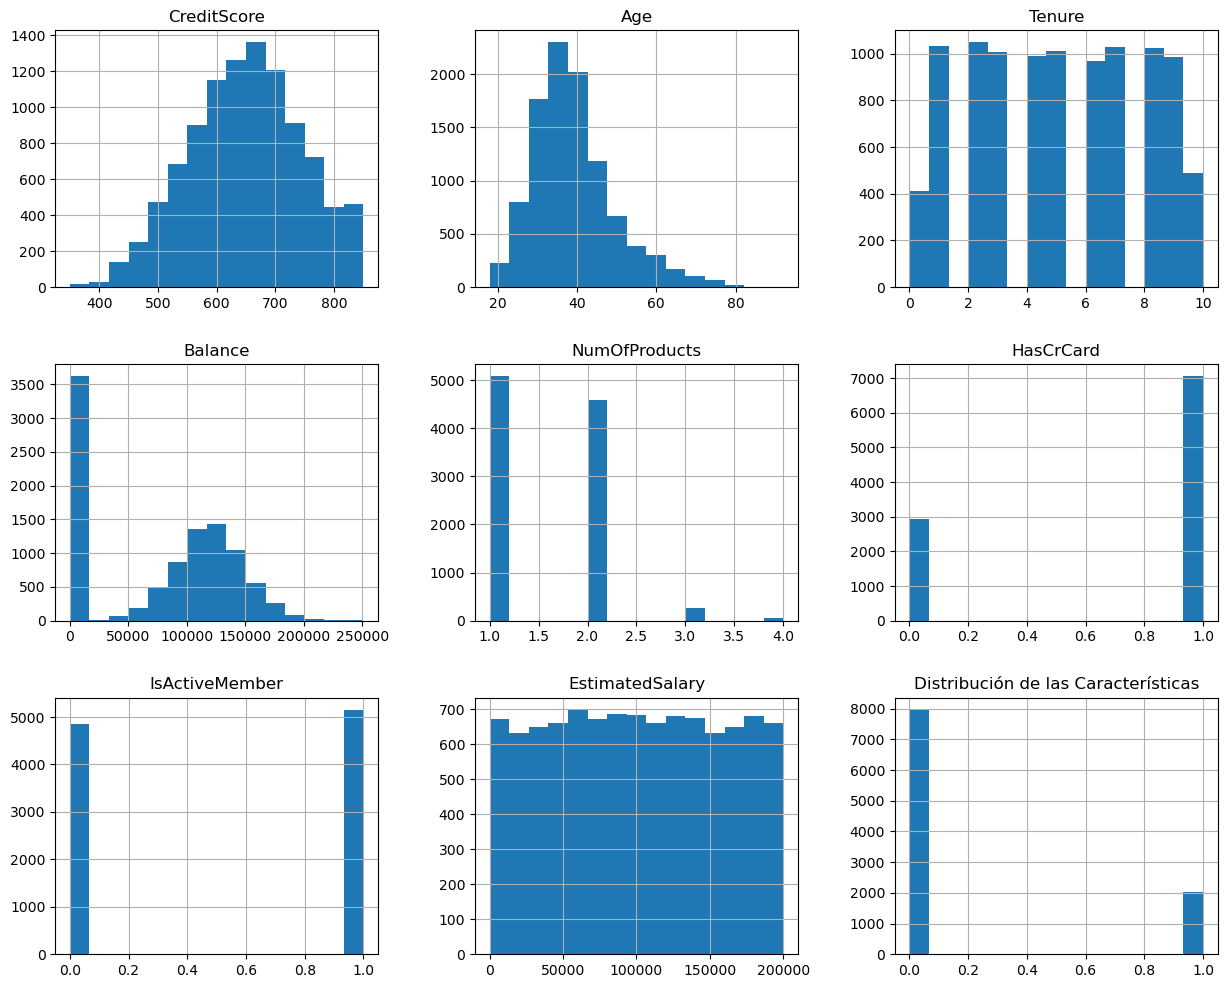

In [9]:
# Distribución de todas las características
churn.hist(figsize=(15,12), bins=15)
plt.title("Distribución de las Características")
plt.show()

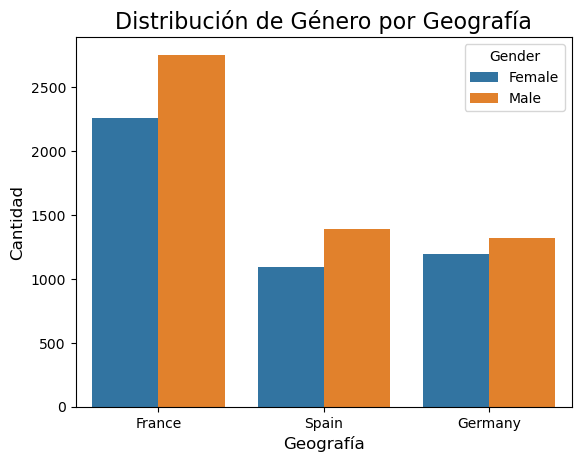

In [10]:
# Usamos un gráfico de barras agrupadas para mostrar las características de 'Geography' y 'Gender'
sns.countplot(x='Geography', hue='Gender', data=churn)

# Añadimos título y etiquetas
plt.title('Distribución de Género por Geografía', fontsize=16)
plt.xlabel('Geografía', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

# Mostramos el gráfico
plt.show()

In [11]:
churn['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [12]:
churn['Geography']= churn['Geography'].map({'France':0,'Germany':1,'Spain':2})
churn['Gender'] = churn['Gender'].map({'Female':0,'Male':1})

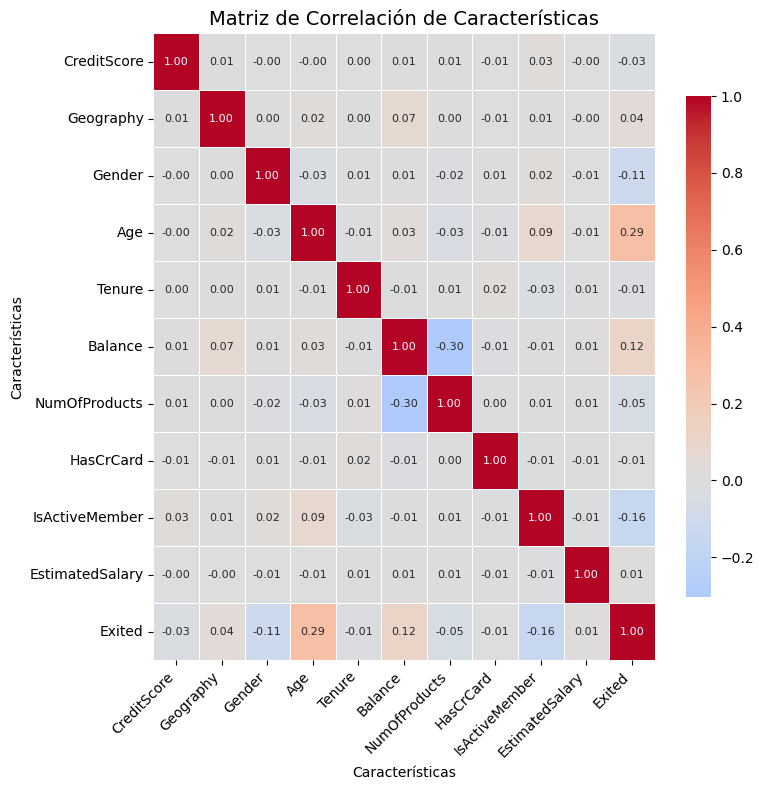

In [13]:
# Ajustando el tamaño de la figura
plt.figure(figsize=(8, 8))

# Creando el heatmap con mejoras
sns.heatmap(
    churn.corr(), annot=True, cmap="coolwarm",  center=0, fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8},  annot_kws={'size': 8},
)


# Añadir título y etiquetas a los ejes
plt.title("Matriz de Correlación de Características", fontsize=14)  
plt.xlabel("Características", fontsize=10)  
plt.ylabel("Características", fontsize=10)

# Mejorar la legibilidad de los ticks
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.yticks(rotation=0, fontsize=10)

# Mostrar el gráfico
plt.tight_layout()  
plt.show()

#### Entrenamiento

In [14]:
x = churn.drop(['Exited'], axis=1)
y = churn.Exited

In [15]:
x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,,
1,619,0,0,42,2,0.00,1,1,1,101348.88
2,608,2,0,41,1,83807.86,1,0,1,112542.58
3,502,0,0,42,8,159660.80,3,1,0,113931.57
4,699,0,0,39,1,0.00,2,0,0,93826.63
5,850,2,0,43,2,125510.82,1,1,1,79084.10


In [16]:
y

RowNumber
1        1
2        0
3        1
4        0
5        0
        ..
9996     0
9997     0
9998     1
9999     1
10000    0
Name: Exited, Length: 10000, dtype: int64

### Red Neuronal

In [17]:
# Ignorar los warnings
warnings.filterwarnings('ignore')

# Definiendo el modelo
model = Sequential(
    [
        # Añadiendo la capa de entrada y la primera capa oculta
        Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=10),
        # Añadiendo la segunda capa oculta
        Dense(units=6, kernel_initializer='uniform', activation='relu'),
        # Añadiendo la capa de salida
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid'),
    ]
)

# Compilando la ANN | Esto significa aplicar el optimizador Adam en toda la ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115 (460.00 B)

 Trainable params: 115 (460.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Dividir el conjunto de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Escalar las características
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Ajustando la ANN al conjunto de entrenamiento
history = model.fit(x_train, y_train, batch_size=10,  epochs=100, verbose=1,  validation_split=0.2)   

Epoch 1/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7840 - loss: 0.5883 - val_accuracy: 0.7969 - val_loss: 0.4330
Epoch 2/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7862 - loss: 0.4419 - val_accuracy: 0.8225 - val_loss: 0.4229
Epoch 3/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8164 - loss: 0.4229 - val_accuracy: 0.8281 - val_loss: 0.4134
Epoch 4/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8296 - loss: 0.4056 - val_accuracy: 0.8244 - val_loss: 0.4039
Epoch 5/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8307 - loss: 0.3948 - val_accuracy: 0.8256 - val_loss: 0.3980
Epoch 6/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8308 - loss: 0.3896 - val_accuracy: 0.8231 - val_loss: 0.3918
Epoch 7/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8232 - loss: 0.3908 - val_accuracy: 0.8269 - val_loss: 0.3898
Epoch 8/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8452 - loss: 0.3690 - val_ac

### Evaluacion Metricas

In [19]:
# Evaluando la ANN en el conjunto de entrenamiento
score, acc = model.evaluate(x_train, y_train, batch_size=10)
print('Puntuación de entrenamiento:', score)
print('Precisión de entrenamiento:', acc)

800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8661 - loss: 0.3323
Puntuación de entrenamiento: 0.3426620066165924
Precisión de entrenamiento: 0.859125018119812


In [20]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [21]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [22]:
accuracy_score(y_test,y_pred)

0.8595

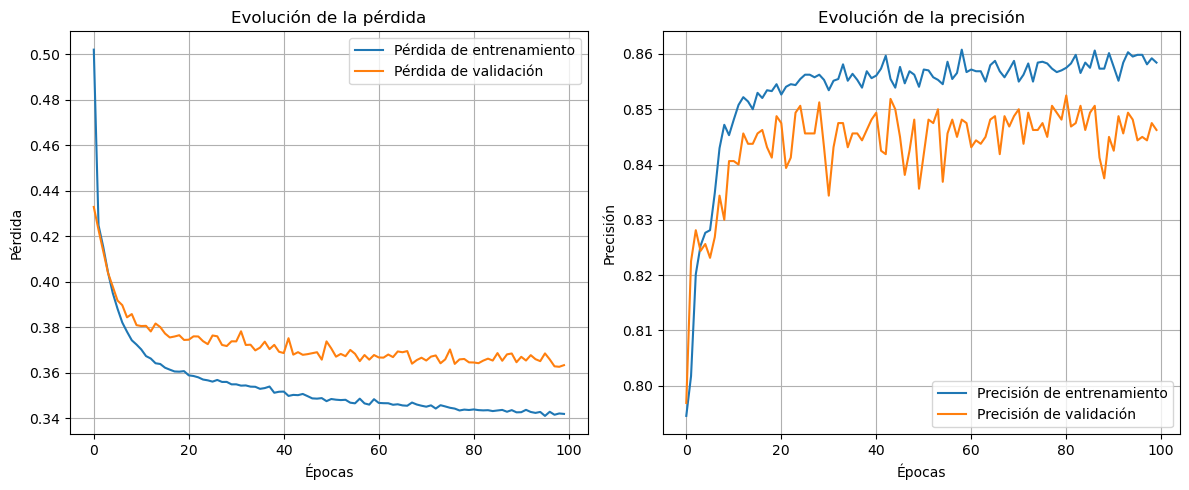

In [23]:
# Gráfico de la pérdida
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()
plt.show()

Text(0.5, 23.52222222222222, 'Etiqueta predicha')

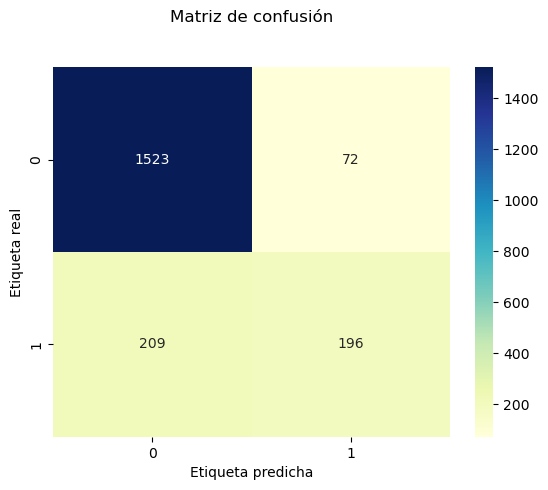

In [24]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización con mapa de calor
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap='YlGnBu', fmt='g')
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')


In [25]:
# import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1595
           1       0.73      0.48      0.58       405

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


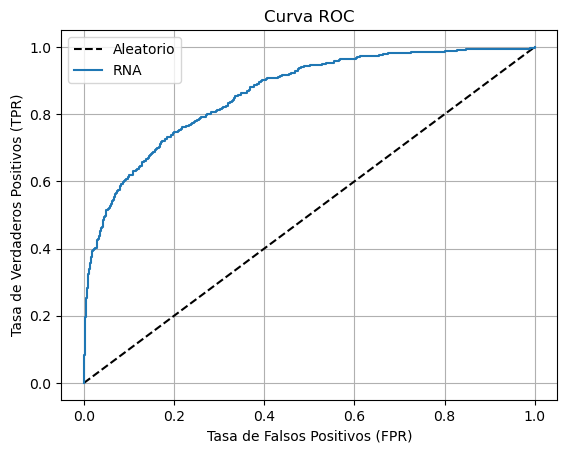

In [26]:
# Predecir probabilidades utilizando el modelo
y_pred_proba = model.predict(x_test)

# Suponiendo que y_test es binario (0 y 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la curva ROC
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')  
plt.plot(fpr, tpr, label='RNA')  
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

### Prediccion de Sistema

In [27]:
x_test_reshaped = x_test[5].reshape(1, -1)
result = model.predict(x_test_reshaped)
(result > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


array([[1]])

In [28]:
y_test.iloc[5]

1

In [29]:
def pred(CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary):
    features = np.array([CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary])
    features = features.reshape(1, -1)  # Reshape to (1, input_dim)
    result = model.predict(features)
    result = (result > 0.5).astype(int)
    return result

In [30]:
# EJemplo de uso:
CreditScore = 619
Geography = 0
Gender = 0
Age = 42
Tenure = 2
Balance = 0.0
NumOfProducts = 1
HasCrCard = 1
IsActiveMember = 1
EstimatedSalary = 101348.88

result = pred(CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary)
print(result)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
[[0]]


In [31]:
if result == 1:
    print("Abandono")  # Churn
else:
    print("No hay abandono") 

No hay abandono


In [33]:
churn.iloc[0]

CreditScore           619.00
Geography               0.00
Gender                  0.00
Age                    42.00
Tenure                  2.00
Balance                 0.00
NumOfProducts           1.00
HasCrCard               1.00
IsActiveMember          1.00
EstimatedSalary    101348.88
Exited                  1.00
Name: 1, dtype: float64

#### Guardar modelo

In [34]:
model.save('model.h5')